# Boston house prices regression

https://predictivemodeler.com/2019/10/19/tensorflow-boston-house-prices/

# Environment Check



In [624]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.backend as K


print(pd.__version__)
print(sns.__version__)
print(tf.__version__)
print(keras.__version__)

1.0.0
0.9.0
2.2.0
2.3.0-tf


# Data Exploration

In [625]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape) #get (numer of rows, number of columns or 'features')
print(boston.DESCR) #get a description of the dataset
# Next, we load the data into a 'dataframe' object for easier manipulation, and also print the first few rows in order to examine it
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data.head() #notice that the target variable (MEDV) is not included

(506, 13)
.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - P

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [626]:
#For some reason, the loaded data does not include the target variable (MEDV), we add it here
data['MEDV'] = pd.Series(data=boston.target, index=data.index)
#print(boston.target)
data.describe() #get some basic stats on the dataset

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [627]:
data.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0.0,0.573,6.030,80.8,2.5050,1.0,273.0,21.0,396.90,7.88,11.9


In [628]:
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Drop rows with null values if required

In [629]:
data = data.dropna(axis=0)

### Split Data between training set and test set

In [630]:
train_dataset = data.sample(frac=0.7,random_state=0)
test_dataset = data.drop(train_dataset.index)

## Data Inspection

Joint distribution of input variables

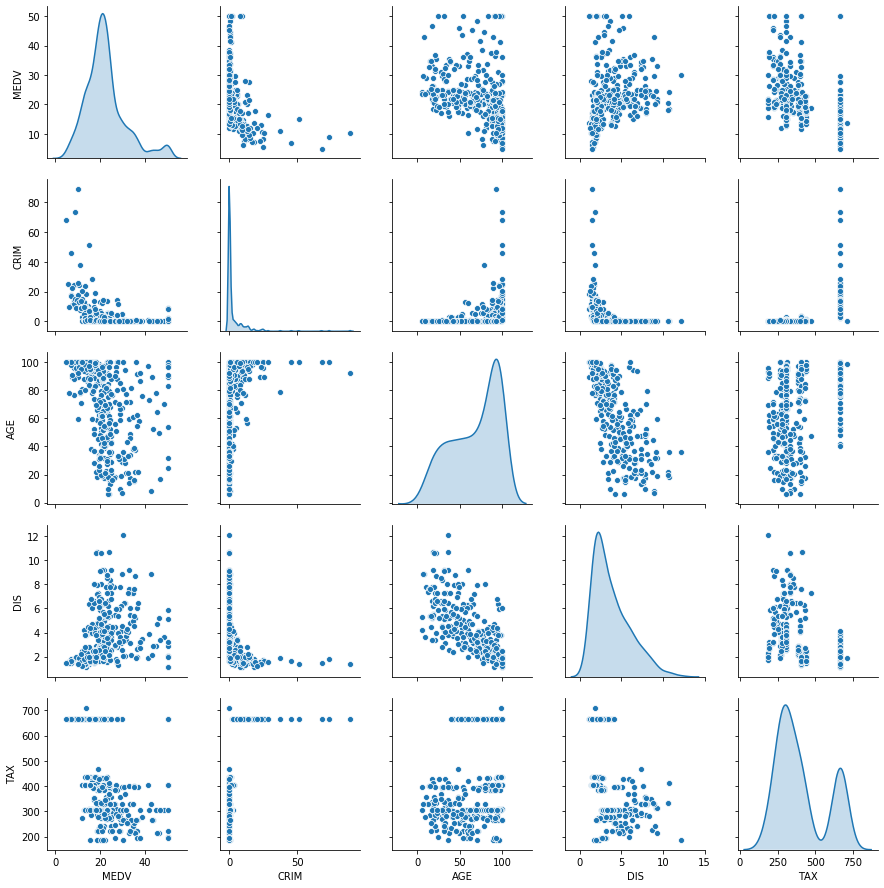

In [631]:
sns.pairplot(train_dataset[["MEDV", "CRIM","AGE","DIS","TAX"]], diag_kind="kde")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efd7cdec128>,
      dtype=object)

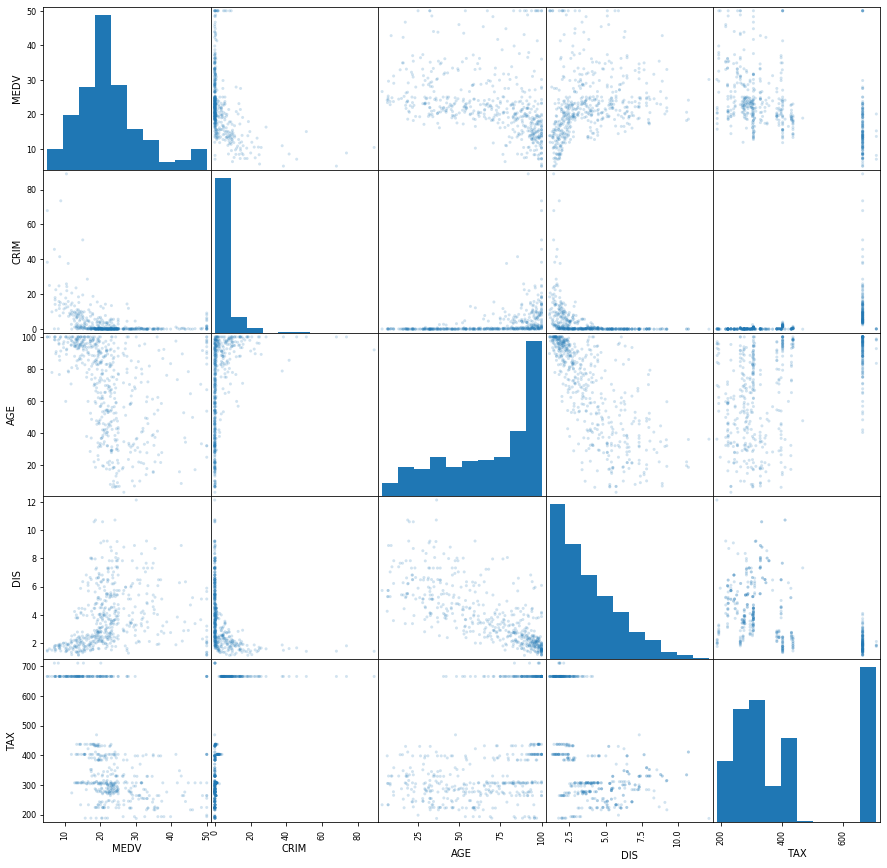

In [632]:
pd.plotting.scatter_matrix(data[["MEDV", "CRIM","AGE","DIS","TAX"]], alpha=0.2, figsize=(15, 15), diagonal='hist')

In [633]:
train_stats = train_dataset.describe()
train_stats.pop("MEDV")
train_stats = train_stats.transpose()
train_stats['mean']

CRIM         3.767375
ZN          11.079096
INDUS       11.185254
CHAS         0.070621
NOX          0.554098
RM           6.265791
AGE         68.057627
DIS          3.844439
RAD          9.440678
TAX        407.500000
PTRATIO     18.461299
B          352.720650
LSTAT       12.614011
Name: mean, dtype: float64

In [634]:
train_labels = train_dataset.pop('MEDV')
print("train_labels : ", train_labels)
test_labels = test_dataset.pop('MEDV')
print("test_labels : ", test_labels)

train_labels :  329    22.6
371    50.0
219    23.0
403     8.3
78     21.2
       ... 
182    37.9
453    17.8
80     28.0
307    28.2
258    36.0
Name: MEDV, Length: 354, dtype: float64
test_labels :  0      24.0
9      18.9
11     18.9
23     14.5
25     13.9
       ... 
489     7.0
490     8.1
492    20.1
493    21.8
504    22.0
Name: MEDV, Length: 152, dtype: float64


## Data Normalization

This normalized data is what we will use to train the model.

             CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
CRIM     1.000000 -0.188639  0.397124 -0.069178  0.392504 -0.220317  0.345915   
ZN      -0.188639  1.000000 -0.547373 -0.032057 -0.515339  0.268030 -0.568698   
INDUS    0.397124 -0.547373  1.000000  0.054502  0.766875 -0.384581  0.636038   
CHAS    -0.069178 -0.032057  0.054502  1.000000  0.106314  0.078692  0.077565   
NOX      0.392504 -0.515339  0.766875  0.106314  1.000000 -0.301139  0.728103   
RM      -0.220317  0.268030 -0.384581  0.078692 -0.301139  1.000000 -0.220935   
AGE      0.345915 -0.568698  0.636038  0.077565  0.728103 -0.220935  1.000000   
DIS     -0.362270  0.703160 -0.719541 -0.099332 -0.766687  0.216125 -0.745411   
RAD      0.610721 -0.303663  0.591136 -0.043833  0.591166 -0.225564  0.439996   
TAX      0.578482 -0.292244  0.682752 -0.073036  0.646296 -0.301010  0.471910   
PTRATIO  0.278218 -0.353443  0.331789 -0.183024  0.163784 -0.347392  0.243678   
B       -0.420750  0.181975 

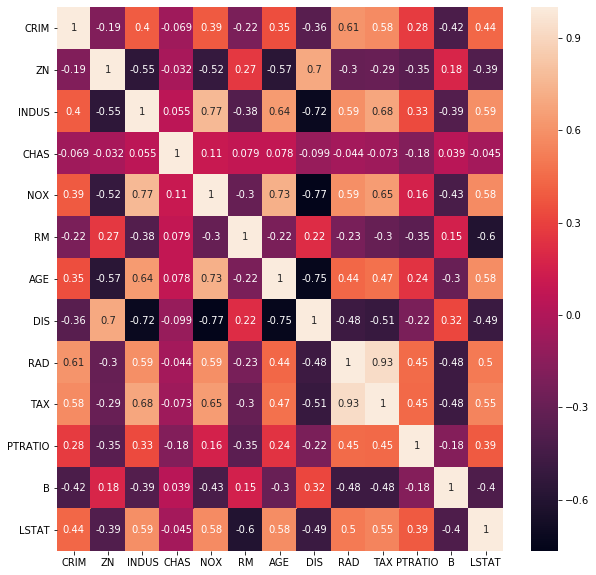

In [635]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

corrMatrix = normed_train_data.corr()
print(corrMatrix)
plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [636]:
eigVals, eigVecs = tf.linalg.eigh(corrMatrix)
print(eigVals)
print(eigVecs)
principal_components = np.matmul(test_dataset, eigVecs.numpy())
print(principal_components)
factor_loadings = principal_components * eigVals
print(factor_loadings)
abc = np.matmul(factor_loadings, tf.transpose(eigVecs.numpy()))
print(abc.sum(axis=1))
print(test_labels)

tf.Tensor(
[0.05856669 0.16420004 0.18049025 0.23534003 0.27585375 0.42200136
 0.54367883 0.6049016  0.78112532 0.89942269 1.21689536 1.53803067
 6.07949342], shape=(13,), dtype=float64)
tf.Tensor(
[[-0.03851233  0.11774292 -0.01922679 -0.00894267  0.21703494 -0.1807625
   0.81796842 -0.10408118  0.00139876 -0.05236635  0.2677136  -0.2974408
   0.24826094]
 [ 0.08529628 -0.23289624  0.27010783  0.14673298  0.39868014  0.40940186
  -0.17493063 -0.32376485  0.11888887 -0.31500468  0.30664631 -0.3313134
  -0.25466037]
 [ 0.16652431 -0.07734624 -0.32911487 -0.44551876  0.62013966 -0.20816901
  -0.27423828 -0.13860092  0.00335643 -0.01148052 -0.01794253  0.13046522
   0.34593798]
 [-0.03532947 -0.00851991 -0.00876852 -0.00201814 -0.01312472  0.02636356
   0.05907634  0.18235109 -0.56348778 -0.60368789  0.29228206  0.43999896
  -0.00190237]
 [ 0.02705387  0.71687895  0.35521394  0.25535624  0.08945689  0.00120342
  -0.19930513 -0.17835708  0.169528   -0.02516492  0.12295513  0.22996027
   0.

## Callbacks for precision, callback and F1 Score

In [637]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def computeF1Score(true_positives, predicted_positives):
    true_positives = K.sum(K.round(K.clip(true_positives * predicted_positives, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(true_positives, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    precision = true_positives / (predicted_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Setup Model

In [638]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

optimizer = tf.keras.optimizers.RMSprop(0.001)
optimizer2 = tf.keras.optimizers.Adam(0.001)
optimizer3 = tf.keras.optimizers.SGD(0.001)


def build_model_with_dropout():
  model = keras.Sequential([
    layers.Dropout(0.2, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5), 
                 bias_regularizer=regularizers.l2(1e-4), 
                 activity_regularizer=regularizers.l2(1e-5)
                ),
    layers.Dense(1)
  ])
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', precision_m, recall_m, f1_m, computeF1Score])
  return model


def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu', 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5), 
                 bias_regularizer=regularizers.l2(1e-4), 
                 activity_regularizer=regularizers.l2(1e-5)
                ),
    layers.Dense(1)
  ])
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', precision_m, recall_m, f1_m, computeF1Score])
  return model

#build model
model = build_model();

## Inspect the model setup

In [639]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_129 (Dense)            (None, 64)                896       
_________________________________________________________________
dense_130 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [640]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.45693162],
       [-0.1495394 ],
       [-0.17211771],
       [-0.43484917],
       [ 0.12756729],
       [ 0.05327767],
       [-0.3172925 ],
       [ 0.10569036],
       [ 0.33731055],
       [-0.1664229 ]], dtype=float32)

## Train the model

In [641]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100
#API
#fit( x=None, y=None, epochs=1, validation_split=0.0, verbose=1, callbacks=None)

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

### Visualize the model's training progress

In [642]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,precision_m,recall_m,f1_m,computeF1Score,val_loss,val_mae,val_mse,val_precision_m,val_recall_m,val_f1_m,val_computeF1Score,epoch
95,10.510801,2.102954,9.819151,1.0,1.0,1.0,3.095057,7.567751,2.068671,6.871357,1.0,1.0,1.0,2.635540,95
96,10.297665,2.121420,9.603121,1.0,1.0,1.0,3.070651,7.343582,2.016939,6.651247,1.0,1.0,1.0,2.703184,96
97,9.984818,2.055215,9.291919,1.0,1.0,1.0,3.110220,7.776031,2.095912,7.077302,1.0,1.0,1.0,2.618468,97
98,10.130683,2.090000,9.435513,1.0,1.0,1.0,3.089094,7.974278,2.138745,7.279664,1.0,1.0,1.0,2.665596,98
99,10.194282,2.096022,9.498865,1.0,1.0,1.0,3.084867,7.349892,2.007095,6.652445,1.0,1.0,1.0,2.665491,99


### Error plots

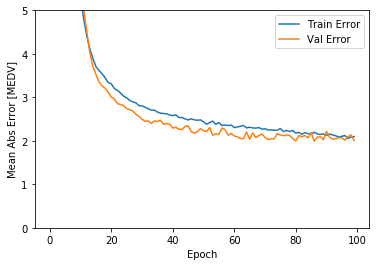

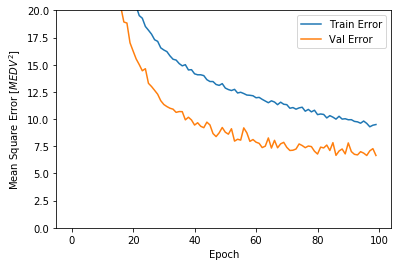

In [643]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MEDV]')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MEDV^2$]')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or actually a fairly severe degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [644]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


......................................................................................

## Error Plots after Early Stops

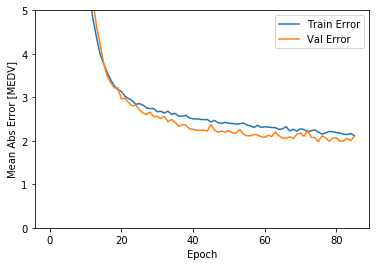

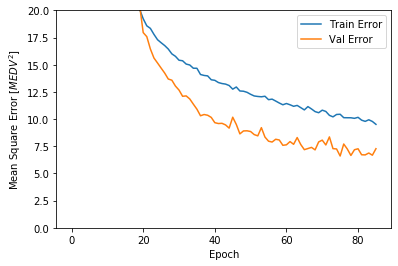

In [645]:
plot_history(history)

In [646]:
model.evaluate(normed_test_data, test_labels, verbose=2)
#print(mae)
#print("Testing set Mean Abs Error: {:5.2f} MEDV".format(mae))

5/5 - 0s - loss: 12.8559 - mae: 2.4989 - mse: 12.1751 - precision_m: 1.0000 - recall_m: 1.0000 - f1_m: 1.0000 - computeF1Score: 2.8108


[12.855947494506836,
 2.498898983001709,
 12.17505168914795,
 1.0,
 1.0,
 1.0,
 2.8107573986053467]

## Model Plotting

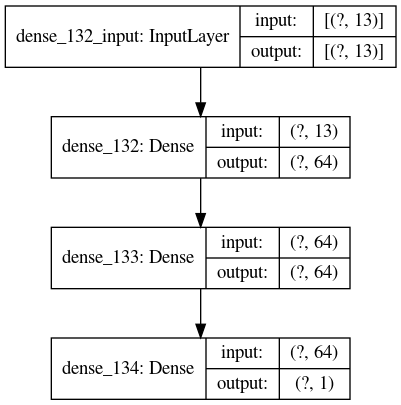

In [647]:
dot_img_file = '/tmp/boston_housing.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Manual metrics using sciki Learn

In [648]:
# Only for classification
# accuracy: (tp + tn) / (p + n)
#accuracy = accuracy_score(test_labels, test_predictions)
#print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
#precision = precision_score(test_labels, test_predictions)
#print('Precision: %f' % precision)
# recall: tp / (tp + fn)
#recall = recall_score(test_labels, test_predictions)
#print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
#f1 = f1_score(test_labels, test_predictions)
#print('F1 score: %f' % f1)

## Plot test labels and predicted lables

Perfect scenario when $ y = \hat{y}$

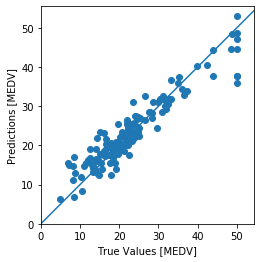

In [649]:
test_predictions = model.predict(normed_test_data).flatten()
train_predictions = model.predict(normed_train_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])

# Distribution of errors

Plotting histogram of errors $\hat{e}$

Text(0, 0.5, 'Count')

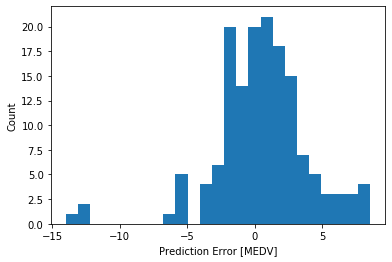

In [650]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
plt.ylabel("Count")

In [651]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(test_labels, test_predictions)
print('Mean Squared Error: ',mse)
mae = mean_absolute_error(test_labels, test_predictions)
print('Mean Absolute Error: ',mae)
rsq = r2_score(train_labels,train_predictions) #R-Squared on the training data
print('R-square, Training: ',rsq)
rsq = r2_score(test_labels,test_predictions) #R-Squared on the testing data
print('R-square, Testing: ',rsq)

Mean Squared Error:  12.175053723624448
Mean Absolute Error:  2.498899114759345
R-square, Training:  0.8865272200767089
R-square, Testing:  0.8769887588666105
